# **Notebook 2a**: EfficientDet

<span style="font-size: 1.5rem;">By **Michael Farrugia**</span>

## Package Installation

In [1]:
INSTALL_PACKAGES = False

In [2]:
if INSTALL_PACKAGES:
    !pip install -r requirements.txt

## Model Setup

In [3]:
import json

with open("./dataset/COCO-based_COCO/annotations/train.json", "r") as f:
    train_annotations = json.load(f)

with open("./dataset/COCO-based_COCO/annotations/val.json", "r") as f:
    val_annotations = json.load(f)

with open("./dataset/COCO-based_COCO/annotations/test.json", "r") as f:
    test_annotations = json.load(f)

print(f"Number of images in the train set: {len(train_annotations ['images'])}")
print(f"Number of images in the validation set: {len(val_annotations ['images'])}")
print(f"Number of images in the test set: {len(test_annotations ['images'])}")

Number of images in the train set: 483
Number of images in the validation set: 88
Number of images in the test set: 86


The images used in this notebook are split according to the `.json` files. To use the images in training, the `images` folder must exist - if this folder does not exist, the cell below is used to create the necessary folders according to how the dataset is split.

In [4]:
import os
import shutil

if not os.path.exists("./dataset/COCO-based_COCO/images/"):
    os.makedirs("./dataset/COCO-based_COCO/images/")

    for dataset, dataset_type in zip([train_annotations, val_annotations, test_annotations], ["train", "val", "test"]):
        os.makedirs(f"./dataset/COCO-based_COCO/images/{dataset_type}/")
        img_filenames = [img ["file_name"] for img in dataset ["images"]]
        
        for img_filename in img_filenames:
            member_name = img_filename.split("-") [1].split("_") [0]

            img_src_path = f"./{member_name}/images/{img_filename}"
            img_dst_path = f"./dataset/COCO-based_COCO/images/{dataset_type}/{img_filename}"
            
            shutil.copyfile(img_src_path, img_dst_path)

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
from effdet import get_efficientdet_config

config = get_efficientdet_config("efficientdet_d0")
config.num_classes = 6
config.image_size = (512, 512)

In [7]:
from effdet import EfficientDet

model = EfficientDet(config, pretrained_backbone = True)
model.to(device)

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


EfficientDet(
  (backbone): EfficientNetFeatures(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (co

## Model Training

In [8]:
import albumentations as A

def transform():
    return A.Compose([
            A.Resize(512, 512),
            A.HorizontalFlip(p = 0.5),
            A.ShiftScaleRotate(shift_limit = 0.0625, scale_limit = 0.1, rotate_limit = 15, p = 0.5),
            A.RandomBrightnessContrast(p = 0.5),
            A.ColorJitter(p = 0.5),
            A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
            A.pytorch.ToTensorV2()
    ], bbox_params = A.BboxParams(format = "coco", label_fields = ["labels"], min_area = 0, min_visibility = 0))

In [9]:
import cv2

class EfficientDetDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, img_dir, transform = None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform

        self.img_id_to_annotations = {}
        for annotation in self.annotations ["annotations"]:
            img_id = annotation ["image_id"]
            if img_id not in self.img_id_to_annotations:
                self.img_id_to_annotations [img_id] = []
            self.img_id_to_annotations [img_id].append(annotation)

        self.imgs = {img ["id"]: img for img in self.annotations ["images"]}
        self.img_ids = list(self.imgs.keys())

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids [index]
        img_info = self.imgs [img_id]
        img_path = os.path.join(self.img_dir, img_info ["file_name"])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        annotations = self.img_id_to_annotations.get(img_id, [])
        
        bboxes = [annotation ["bbox"] for annotation in annotations]
        labels = [annotation ["category_id"] for annotation in annotations]

        if self.transform:
            transformed_image_result = self.transform(image = image, bboxes = bboxes, labels = labels)

            image = transformed_image_result ["image"]
            bboxes = transformed_image_result ["bboxes"]
            labels = transformed_image_result ["labels"]

        # Convert COCO format (x, y, w, h) to xyxy format (x_min, y_min, x_max, y_max)
        if len(bboxes) > 0:
            bboxes_xyxy = []
            for bbox in bboxes:
                x, y, w, h = bbox
                bboxes_xyxy.append([x, y, x + w, y + h])
            
            bboxes = torch.tensor(bboxes_xyxy, dtype = torch.float32)
            labels = torch.tensor(labels, dtype = torch.int64)
        else:
            bboxes = torch.zeros((0, 4), dtype = torch.float32)
            labels = torch.zeros((0,), dtype = torch.int64)

        return image, {"boxes": bboxes, "labels": labels}

In [10]:
train_dataset = EfficientDetDataset(
    annotations = train_annotations,
    img_dir = "./dataset/COCO-based_COCO/images/train/",
    transform = transform()
)

val_dataset = EfficientDetDataset(
    annotations = val_annotations,
    img_dir = "./dataset/COCO-based_COCO/images/val/",
    transform = transform()
)

c:\Users\micha\anaconda3\envs\ARI3129\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


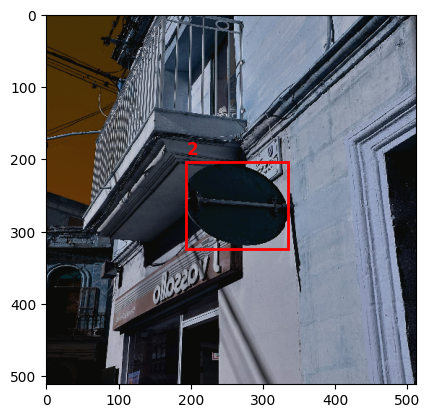

In [ ]:
input, target = train_dataset [0]

boxes = target ["boxes"]
labels = target ["labels"]

from matplotlib import pyplot as plt

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
input_denorm = input * std + mean
input_denorm = input_denorm.permute(1, 2, 0).numpy()
input_denorm = (input_denorm * 255).clip(0, 255).astype("uint8")

plt.imshow(input_denorm)

for box, label in zip(boxes, labels):
    x_min, y_min, x_max, y_max = box

    width = x_max - x_min
    height = y_max - y_min

    rect = plt.Rectangle((x_min, y_min), width, height, fill = False, color = "red", linewidth = 2)
    plt.gca().add_patch(rect)
    plt.gca().text(x_min, y_min - 10, str(label.item()), color = "red", fontsize = 12, weight = "bold")

In [12]:
def efficientdet_collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)

    max_objs = max(target ["boxes"].shape [0] for target in targets)

    padded_boxes = []
    padded_labels = []

    for target in targets:
        boxes = target ["boxes"]
        labels = target ["labels"]

        num_objs = boxes.shape [0]

        padded_box = torch.zeros((max_objs, 4), dtype = torch.float32)
        padded_label = torch.zeros((max_objs,), dtype = torch.int64)

        if num_objs > 0:
            padded_box [:num_objs, :] = boxes
            padded_label [:num_objs] = labels

        padded_boxes.append(padded_box)
        padded_labels.append(padded_label)

    padded_boxes = torch.stack(padded_boxes)
    padded_labels = torch.stack(padded_labels)

    return images, {"bbox": padded_boxes, "cls": padded_labels}

In [13]:
train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    collate_fn = efficientdet_collate_fn,
    num_workers = 0
)

In [14]:
from effdet import DetBenchTrain

effdet_bench = DetBenchTrain(model, config)
effdet_bench.to(device)

DetBenchTrain(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), st

In [15]:
optimiser = torch.optim.AdamW(effdet_bench.parameters(), lr = 1e-4)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/efficientdet")

In [ ]:
for epoch in range(10):
    effdet_bench.train()
    epoch_loss = 0
    epoch_class_loss = 0
    epoch_box_loss = 0

    for batch_idx, (images, targets) in enumerate(train_dataset_loader):
        images = images.to(device)
        targets = {k: v.to(device) for k, v in targets.items()}

        optimiser.zero_grad()

        loss_dict = effdet_bench(images, targets)
        loss = loss_dict ["loss"]
        class_loss = loss_dict ["class_loss"]
        box_loss = loss_dict ["box_loss"]
        
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()
        epoch_class_loss += class_loss.item()
        epoch_box_loss += box_loss.item()

        global_step = epoch * len(train_dataset_loader) + batch_idx
        writer.add_scalar("Loss/batch", loss.item(), global_step)

    avg_loss = epoch_loss / len(train_dataset_loader)
    avg_class_loss = epoch_class_loss / len(train_dataset_loader)
    avg_box_loss = epoch_box_loss / len(train_dataset_loader)

    writer.add_scalar("Loss/train_epoch", avg_loss, epoch)
    writer.add_scalar("Loss/class_loss", avg_class_loss, epoch)
    writer.add_scalar("Loss/box_loss", avg_box_loss, epoch)

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Class Loss: {avg_class_loss:.4f}, Box Loss: {avg_box_loss:.4f}")

writer.close()

Epoch 1, Loss: 4.152452606800174
Epoch 2, Loss: 2.9543088487357148
Epoch 3, Loss: 2.435597637468133
Epoch 4, Loss: 2.2191072534923713
Epoch 5, Loss: 2.147030897376951
Epoch 6, Loss: 2.064155637725326
Epoch 7, Loss: 2.0145959065965386
Epoch 8, Loss: 1.9675667463255322
Epoch 9, Loss: 1.8377270452247179
Epoch 10, Loss: 1.7540753104469993


## Model Saving

In [17]:
os.makedirs("./params", exist_ok = True)

torch.save({
    "epoch": 10,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimiser.state_dict(),
    "config": config,
}, "./params/efficientdet_d0_final.pth")

print("Model saved to ./params/efficientdet_d0_final.pth")

Model saved to ./params/efficientdet_d0_final.pth


## Model Evaluation

In [19]:
from effdet import DetBenchPredict

effdet_pred = DetBenchPredict(model)
effdet_pred.to(device)
effdet_pred.eval()

DetBenchPredict(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), 

In [20]:
val_dataset_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle = False,
    collate_fn = efficientdet_collate_fn,
    num_workers = 0
)

In [23]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision(iou_type="bbox")

with torch.no_grad():
    for images, targets in val_dataset_loader:
        images = images.to(device)
        
        # Get predictions
        outputs = effdet_pred(images)
        
        # Process each image in the batch
        for i in range(images.shape[0]):
            # Get detections for this image
            boxes = outputs[i, :, :4]  # [N, 4]
            scores = outputs[i, :, 4]  # [N]
            classes = outputs[i, :, 5]  # [N]
            
            # Filter valid detections (score > threshold)
            valid_mask = scores > 0.05
            boxes = boxes[valid_mask]
            scores = scores[valid_mask]
            classes = classes[valid_mask]
            
            # Get ground truth for this image
            gt_boxes = targets["bbox"][i]
            gt_labels = targets["cls"][i]
            
            # Filter out padding (boxes with all zeros and label 0)
            valid_gt = gt_labels > 0
            gt_boxes = gt_boxes[valid_gt]
            gt_labels = gt_labels[valid_gt]
            
            # Prepare predictions and targets for metric
            preds = [{
                "boxes": boxes.cpu(),
                "scores": scores.cpu(),
                "labels": classes.long().cpu()
            }]
            
            target = [{
                "boxes": gt_boxes.cpu(),
                "labels": gt_labels.cpu()
            }]
            
            metric.update(preds, target)

# Compute metrics
results = metric.compute()

print(f"mAP: {results['map']:.4f}")
print(f"mAP@50: {results['map_50']:.4f}")
print(f"mAP@75: {results['map_75']:.4f}")
print(f"mAP (small): {results['map_small']:.4f}")
print(f"mAP (medium): {results['map_medium']:.4f}")
print(f"mAP (large): {results['map_large']:.4f}")

NotImplementedError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "c:\Users\micha\anaconda3\envs\ARI3129\Lib\site-packages\effdet\bench.py", line 82, in _batch_detection
        img_scale_i = None if img_scale is None else img_scale[i]
        img_size_i = None if img_size is None else img_size[i]
        detections = generate_detections(
                     ~~~~~~~~~~~~~~~~~~~ <--- HERE
            class_out[i],
            box_out[i],
  File "c:\Users\micha\anaconda3\envs\ARI3129\Lib\site-packages\effdet\anchors.py", line 140, in generate_detections
        scores[top_detection_idx] = soft_scores
    else:
        top_detection_idx = batched_nms(boxes, scores, classes, iou_threshold=0.5)
                            ~~~~~~~~~~~ <--- HERE

    # keep only top max_det_per_image scoring predictions
  File "c:\Users\micha\anaconda3\envs\ARI3129\Lib\site-packages\torchvision\ops\boxes.py", line 83, in batched_nms
        return _batched_nms_vanilla(boxes, scores, idxs, iou_threshold)
    else:
        return _batched_nms_coordinate_trick(boxes, scores, idxs, iou_threshold)
               ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
  File "c:\Users\micha\anaconda3\envs\ARI3129\Lib\site-packages\torchvision\ops\boxes.py", line 102, in _batched_nms_coordinate_trick
    offsets = idxs.to(boxes) * (max_coordinate + torch.tensor(1).to(boxes))
    boxes_for_nms = boxes + offsets[:, None]
    keep = nms(boxes_for_nms, scores, iou_threshold)
           ~~~ <--- HERE
    return keep
  File "c:\Users\micha\anaconda3\envs\ARI3129\Lib\site-packages\torchvision\ops\boxes.py", line 48, in nms
        _log_api_usage_once(nms)
    _assert_has_ops()
    return torch.ops.torchvision.nms(boxes, scores, iou_threshold)
           ~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
RuntimeError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMAIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastMAIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:163 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:375 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:104 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:95 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:108 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:91 [backend fallback]
AutogradMTIA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMAIA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:99 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastMTIA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:466 [backend fallback]
AutocastMAIA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:504 [backend fallback]
AutocastXPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:41 [kernel]
AutocastMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:198 [backend fallback]

